# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns

from matplotlib.lines import Line2D

from joblib import Parallel
from joblib import delayed

from tqdm_joblib import tqdm_joblib

from scipy.stats import ks_2samp

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.decomposition import PCA

from tqdm.autonotebook import tqdm

/Users/dimafilatov/Desktop/science/manuscripts/articles/go_ftir_sfa/research/data_analysis/venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
warnings.filterwarnings("ignore")

np.random.seed(42)

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/03a_train_test_split'

# Loading data

In [4]:
path_to_ftir_data= './../data/preprocessed_data/scaled_data'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-spectra

In [5]:
files = os.listdir(path_to_ftir_data)

In [6]:
data_ranges = {}

for file in files:
    startswith_ftir_flg = file.startswith("ftir")

    if not startswith_ftir_flg:
        continue
    
    high_boundary = int(file.split('_')[-2])
    low_boundary = int(file.split('_')[-1].split('.')[0])

    wn_range = (high_boundary, low_boundary)
    tmp_data = pd.read_csv(f'{path_to_ftir_data}/{file}', sep=';', index_col=0)
    tmp_data.columns = tmp_data.columns.astype(float)

    data_ranges[wn_range] = tmp_data

    print(
        f'-' * 224,
        f'WAVENUMBER RANGE: {wn_range}',
        f'(*) data set shape: {data_ranges[wn_range].shape}',
        f'(*) Wavenumber for data (max/min): {round(data_ranges[wn_range].columns.max()), round(data_ranges[wn_range].columns.min())}',
        sep='\n'
    )

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1800, 1500)
(*) data set shape: (75, 311)
(*) Wavenumber for data (max/min): (1800, 1501)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1500, 1300)
(*) data set shape: (75, 207)
(*) Wavenumber for data (max/min): (1500, 1301)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (3800, 2500)
(*) data set shape: (75, 1348)
(*) Wavenumber for data (max/min): (3800, 250

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1


# *Train/Test* dataset split

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue']
target = samples_description['Class']

In [9]:
type_color_dict = {
    '$d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [10]:
groups = list(type_color_dict.keys())

In [11]:
sns.set_theme()

## Data wrangling

In [12]:
data_range_3800_2500 = data_ranges[(3800, 2500)]

print(data_range_3800_2500.shape)
data_range_3800_2500.head(3)

(75, 1348)


,2500.63184,2501.59622,2502.56060,2503.52498,2504.48935,2505.45373,2506.41811,2507.38249,2508.34687,2509.31124,2510.27562,2511.24000,2512.20438,2513.16876,2514.13313,2515.09751,2516.06189,2517.02627,2517.99065,2518.95502,2519.91940,2520.88378,2521.84816,2522.81253,2523.77691,...,3776.50378,3777.46816,3778.43253,3779.39691,3780.36129,3781.32567,3782.29005,3783.25442,3784.21880,3785.18318,3786.14756,3787.11194,3788.07631,3789.04069,3790.00507,3790.96945,3791.93382,3792.89820,3793.86258,3794.82696,3795.79134,3796.75571,3797.72009,3798.68447,3799.64885
division_1_size_bulk,0.243685,0.244744,0.245992,0.247285,0.248482,0.249497,0.250396,0.251154,0.251732,0.252373,0.253237,0.254230,0.255294,0.256459,0.257737,0.259111,0.260514,0.261825,0.262950,0.263889,0.264755,0.265656,0.266543,0.267316,0.267983,...,0.033396,0.031264,0.029083,0.027069,0.025347,0.023898,0.022674,0.021601,0.020708,0.019822,0.018674,0.017294,0.015689,0.013763,0.011520,0.009079,0.006631,0.004310,0.002283,0.000846,0.000130,0.0000,0.000276,0.000700,0.000842
division_1_size_5,0.099852,0.100480,0.101213,0.102004,0.102743,0.103393,0.103941,0.104360,0.104707,0.105089,0.105533,0.106009,0.106506,0.107023,0.107583,0.108186,0.108794,0.109381,0.109928,0.110442,0.110952,0.111447,0.111850,0.112136,0.112356,...,0.009592,0.008881,0.008096,0.007383,0.006809,0.006360,0.006011,0.005777,0.005618,0.005448,0.005194,0.004800,0.004271,0.003640,0.002983,0.002343,0.001722,0.001129,0.000578,0.000222,0.000108,0.0001,0.000151,0.000164,0.000000
division_1_size_3,0.260135,0.260907,0.261894,0.262998,0.264055,0.265011,0.265845,0.266491,0.267025,0.267589,0.268235,0.268984,0.269754,0.270469,0.271150,0.271851,0.272642,0.273485,0.274272,0.275032,0.275874,0.276738,0.277486,0.278102,0.278602,...,0.027294,0.025648,0.023866,0.022250,0.020902,0.019812,0.018867,0.018009,0.017355,0.016756,0.015904,0.014696,0.013238,0.011509,0.009588,0.007634,0.005709,0.003883,0.002150,0.000807,0.000122,0.0000,0.000347,0.000885,0.001214


In [13]:
data_range_1900_800 = data_ranges[(1900, 800)]

print(data_range_1900_800.shape)
data_range_1900_800.head(3)

(75, 1141)


,800.43364,801.39802,802.36240,803.32677,804.29115,805.25553,806.21991,807.18429,808.14866,809.11304,810.07742,811.04180,812.00618,812.97055,813.93493,814.89931,815.86369,816.82806,817.79244,818.75682,819.72120,820.68558,821.64995,822.61433,823.57871,...,1876.67935,1877.64373,1878.60811,1879.57249,1880.53687,1881.50124,1882.46562,1883.43000,1884.39438,1885.35876,1886.32313,1887.28751,1888.25189,1889.21627,1890.18065,1891.14502,1892.10940,1893.07378,1894.03816,1895.00253,1895.96691,1896.93129,1897.89567,1898.86005,1899.82442
division_1_size_bulk,0.000000,0.000516,0.000882,0.001336,0.001907,0.002571,0.003373,0.004375,0.005656,0.007191,0.008780,0.010284,0.011576,0.012624,0.013544,0.014359,0.014985,0.015417,0.015779,0.016168,0.016655,0.017244,0.017927,0.018759,0.019742,...,0.060491,0.059897,0.059246,0.058564,0.057903,0.057308,0.056810,0.056424,0.056144,0.055917,0.055774,0.055776,0.055900,0.056059,0.056181,0.056309,0.056504,0.056796,0.057157,0.057521,0.057909,0.058318,0.058779,0.059284,0.059731
division_1_size_5,0.055552,0.055756,0.055967,0.056231,0.056588,0.057121,0.057845,0.058691,0.059646,0.060702,0.061783,0.062829,0.063831,0.064753,0.065506,0.066038,0.066399,0.066697,0.066961,0.067175,0.067408,0.067731,0.068212,0.068907,0.069803,...,0.000964,0.001148,0.001297,0.001460,0.001654,0.001879,0.002131,0.002431,0.002802,0.003230,0.003726,0.004286,0.004896,0.005512,0.006097,0.006668,0.007201,0.007691,0.008149,0.008610,0.009109,0.009631,0.010235,0.010927,0.011638
division_1_size_3,0.000000,0.000943,0.001991,0.003207,0.004509,0.005919,0.007426,0.008992,0.010692,0.012505,0.014248,0.015835,0.017290,0.018675,0.020042,0.021341,0.022514,0.023595,0.024655,0.025764,0.026935,0.028115,0.029368,0.030817,0.032525,...,0.054165,0.053819,0.053387,0.052983,0.052705,0.052572,0.052554,0.052646,0.052863,0.053136,0.053431,0.053746,0.054070,0.054338,0.054516,0.054739,0.055078,0.055484,0.055898,0.056312,0.056743,0.057164,0.057626,0.058094,0.058461


In [14]:
data_range_3800_2500_arr = np.asarray(data_range_3800_2500)
data_range_1900_800_arr = np.asarray(data_range_1900_800)

data_range_3800_2500_1900_800_arr = np.hstack([data_range_3800_2500_arr, data_range_1900_800_arr])

print(
    f'Shapes of ranges: ',
    f'(*) 3800-2500: {data_range_3800_2500_arr.shape}',
    f'(*) 1900-800: {data_range_3800_2500_arr.shape}',
    f'(*) 3800-2500 & 1900-800: {data_range_3800_2500_1900_800_arr.shape}',
    sep='\n'
)

Shapes of ranges: 
(*) 3800-2500: (75, 1348)
(*) 1900-800: (75, 1348)
(*) 3800-2500 & 1900-800: (75, 2489)


## *PCA*-based dimensionality reduction

### Base functions

In [15]:
def ks_similarity_1d(train_vals, test_vals):
    _, p = ks_2samp(train_vals, test_vals, alternative='two-sided', mode='auto')
    return p

In [16]:
def kl_divergence_1d(train_vals, test_vals, bins='fd', min_bins=5, max_bins=20, prior=0.5, return_edges=False):
    train_vals = np.asarray(train_vals).ravel()
    test_vals  = np.asarray(test_vals).ravel()
    data = np.concatenate([train_vals, test_vals])

    # Calculation bins using Freedman–Diaconis rule
    edges = np.histogram_bin_edges(data, bins=bins)

    nb = len(edges) - 1
    n_eff = min(train_vals.size, test_vals.size)
    max_bins_eff = max_bins if n_eff >= 2 * max_bins else max(min_bins, n_eff // 2)

    nb = int(np.clip(nb, min_bins, max_bins_eff))
    edges = np.linspace(data.min(), data.max(), nb + 1)

    # Histograms calculation
    p_counts, _ = np.histogram(train_vals, bins=edges, density=False)
    q_counts, _ = np.histogram(test_vals,  bins=edges, density=False)

    # Laplace (prior = 1.0) / Jeffreys (prior = 0.5) smoothing
    p = p_counts.astype(float) + prior
    q = q_counts.astype(float) + prior
    p /= p.sum()
    q /= q.sum()

    # Symmetric KL-divergence calculation
    d_pq = np.sum(p * (np.log(p) - np.log(q)))
    d_qp = np.sum(q * (np.log(q) - np.log(p)))
    kl_val = 0.5 * (d_pq + d_qp)

    if return_edges:
        return kl_val, edges
    return kl_val

In [17]:
def split_similarity(train_idx, test_idx, X_scores, n_pcs=None, metric='ks', kl_params=None, return_details=False):
    X = np.asarray(X_scores)
    if n_pcs is None:
        n_pcs = X.shape[1]
    n_pcs = int(min(n_pcs, X.shape[1]))

    sims = []
    details = {'per_pc': []}
    edges_list = [] # only for metric='kl'

    if metric == 'ks':
        for k in range(n_pcs):
            tr = X[train_idx, k]
            te = X[test_idx,  k]
            val = ks_similarity_1d(tr, te)
            sims.append(val)
            if return_details:
                details['per_pc'].append({'pc': k, 'ks_pvalue': val})
        score = float(np.mean(sims)) if sims else float('nan')
        if return_details:
            return score, details
        return score

    elif metric == 'kl':
        kp = dict(bins='fd', min_bins=5, max_bins=20, prior=0.5)
        if kl_params:
            kp.update(kl_params)
        for k in range(n_pcs):
            tr = X[train_idx, k]
            te = X[test_idx,  k]
            if return_details:
                kl, edges = kl_divergence_1d(tr, te, return_edges=True, **kp)
                edges_list.append(edges)
                sims.append(-kl)
                details['per_pc'].append({'pc': k, 'kl_sym': kl})
            else:
                kl = kl_divergence_1d(tr, te, return_edges=False, **kp)
                sims.append(-kl)
        score = float(np.mean(sims)) if sims else float('nan')
        if return_details:
            details['edges_list'] = edges_list
            return score, details
        return score

    else:
        raise ValueError("Metric must be 'ks' or 'kl'")

### Data scaling

In [18]:
SCALING_CENTER_ONLY = True

In [19]:
X = data_range_3800_2500_1900_800_arr.copy()

if SCALING_CENTER_ONLY:
    X_pca = X - X.mean(axis=0, keepdims=True)
else:
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_pca = scaler.fit_transform(X)

### Principal component analysis (*PCA*)

#### Calculation process

In [20]:
pca = PCA(
    n_components=10,
    random_state=42
)

principal_components_all_df = pd.DataFrame(pca.fit_transform(X_pca))

print(principal_components_all_df.shape)
principal_components_all_df.head(3)

(75, 10)


,0,1,2,3,4,5,6,7,8,9
0,6.193704,1.853621,-2.375375,2.377694,-0.659064,0.381487,0.373778,0.241745,-0.431608,1.652199
1,7.848732,1.508956,-4.276829,-0.352333,-0.418396,-0.122660,0.761963,0.307923,-1.898053,0.392945
2,5.580336,1.095111,-2.059692,2.070278,-0.968862,1.851787,1.633451,-0.535373,-1.020106,1.223280


In [21]:
explained_variance_lst = pca.explained_variance_ratio_

print(f'Explained variance:')
for i in range(len(explained_variance_lst)):
    print(f'(*) component {i + 1}: {round(explained_variance_lst[i] * 100)}%')

Explained variance:
(*) component 1: 36%
(*) component 2: 22%
(*) component 3: 18%
(*) component 4: 10%
(*) component 5: 4%
(*) component 6: 2%
(*) component 7: 2%
(*) component 8: 1%
(*) component 9: 1%
(*) component 10: 1%


#### Visualization the EVR ~ NPC

In [22]:
evr = np.array(pca.explained_variance_ratio_)
x = np.arange(1, evr.size + 1)
cum_evr = np.cumsum(evr) * 100

In [23]:
fontsize = 14

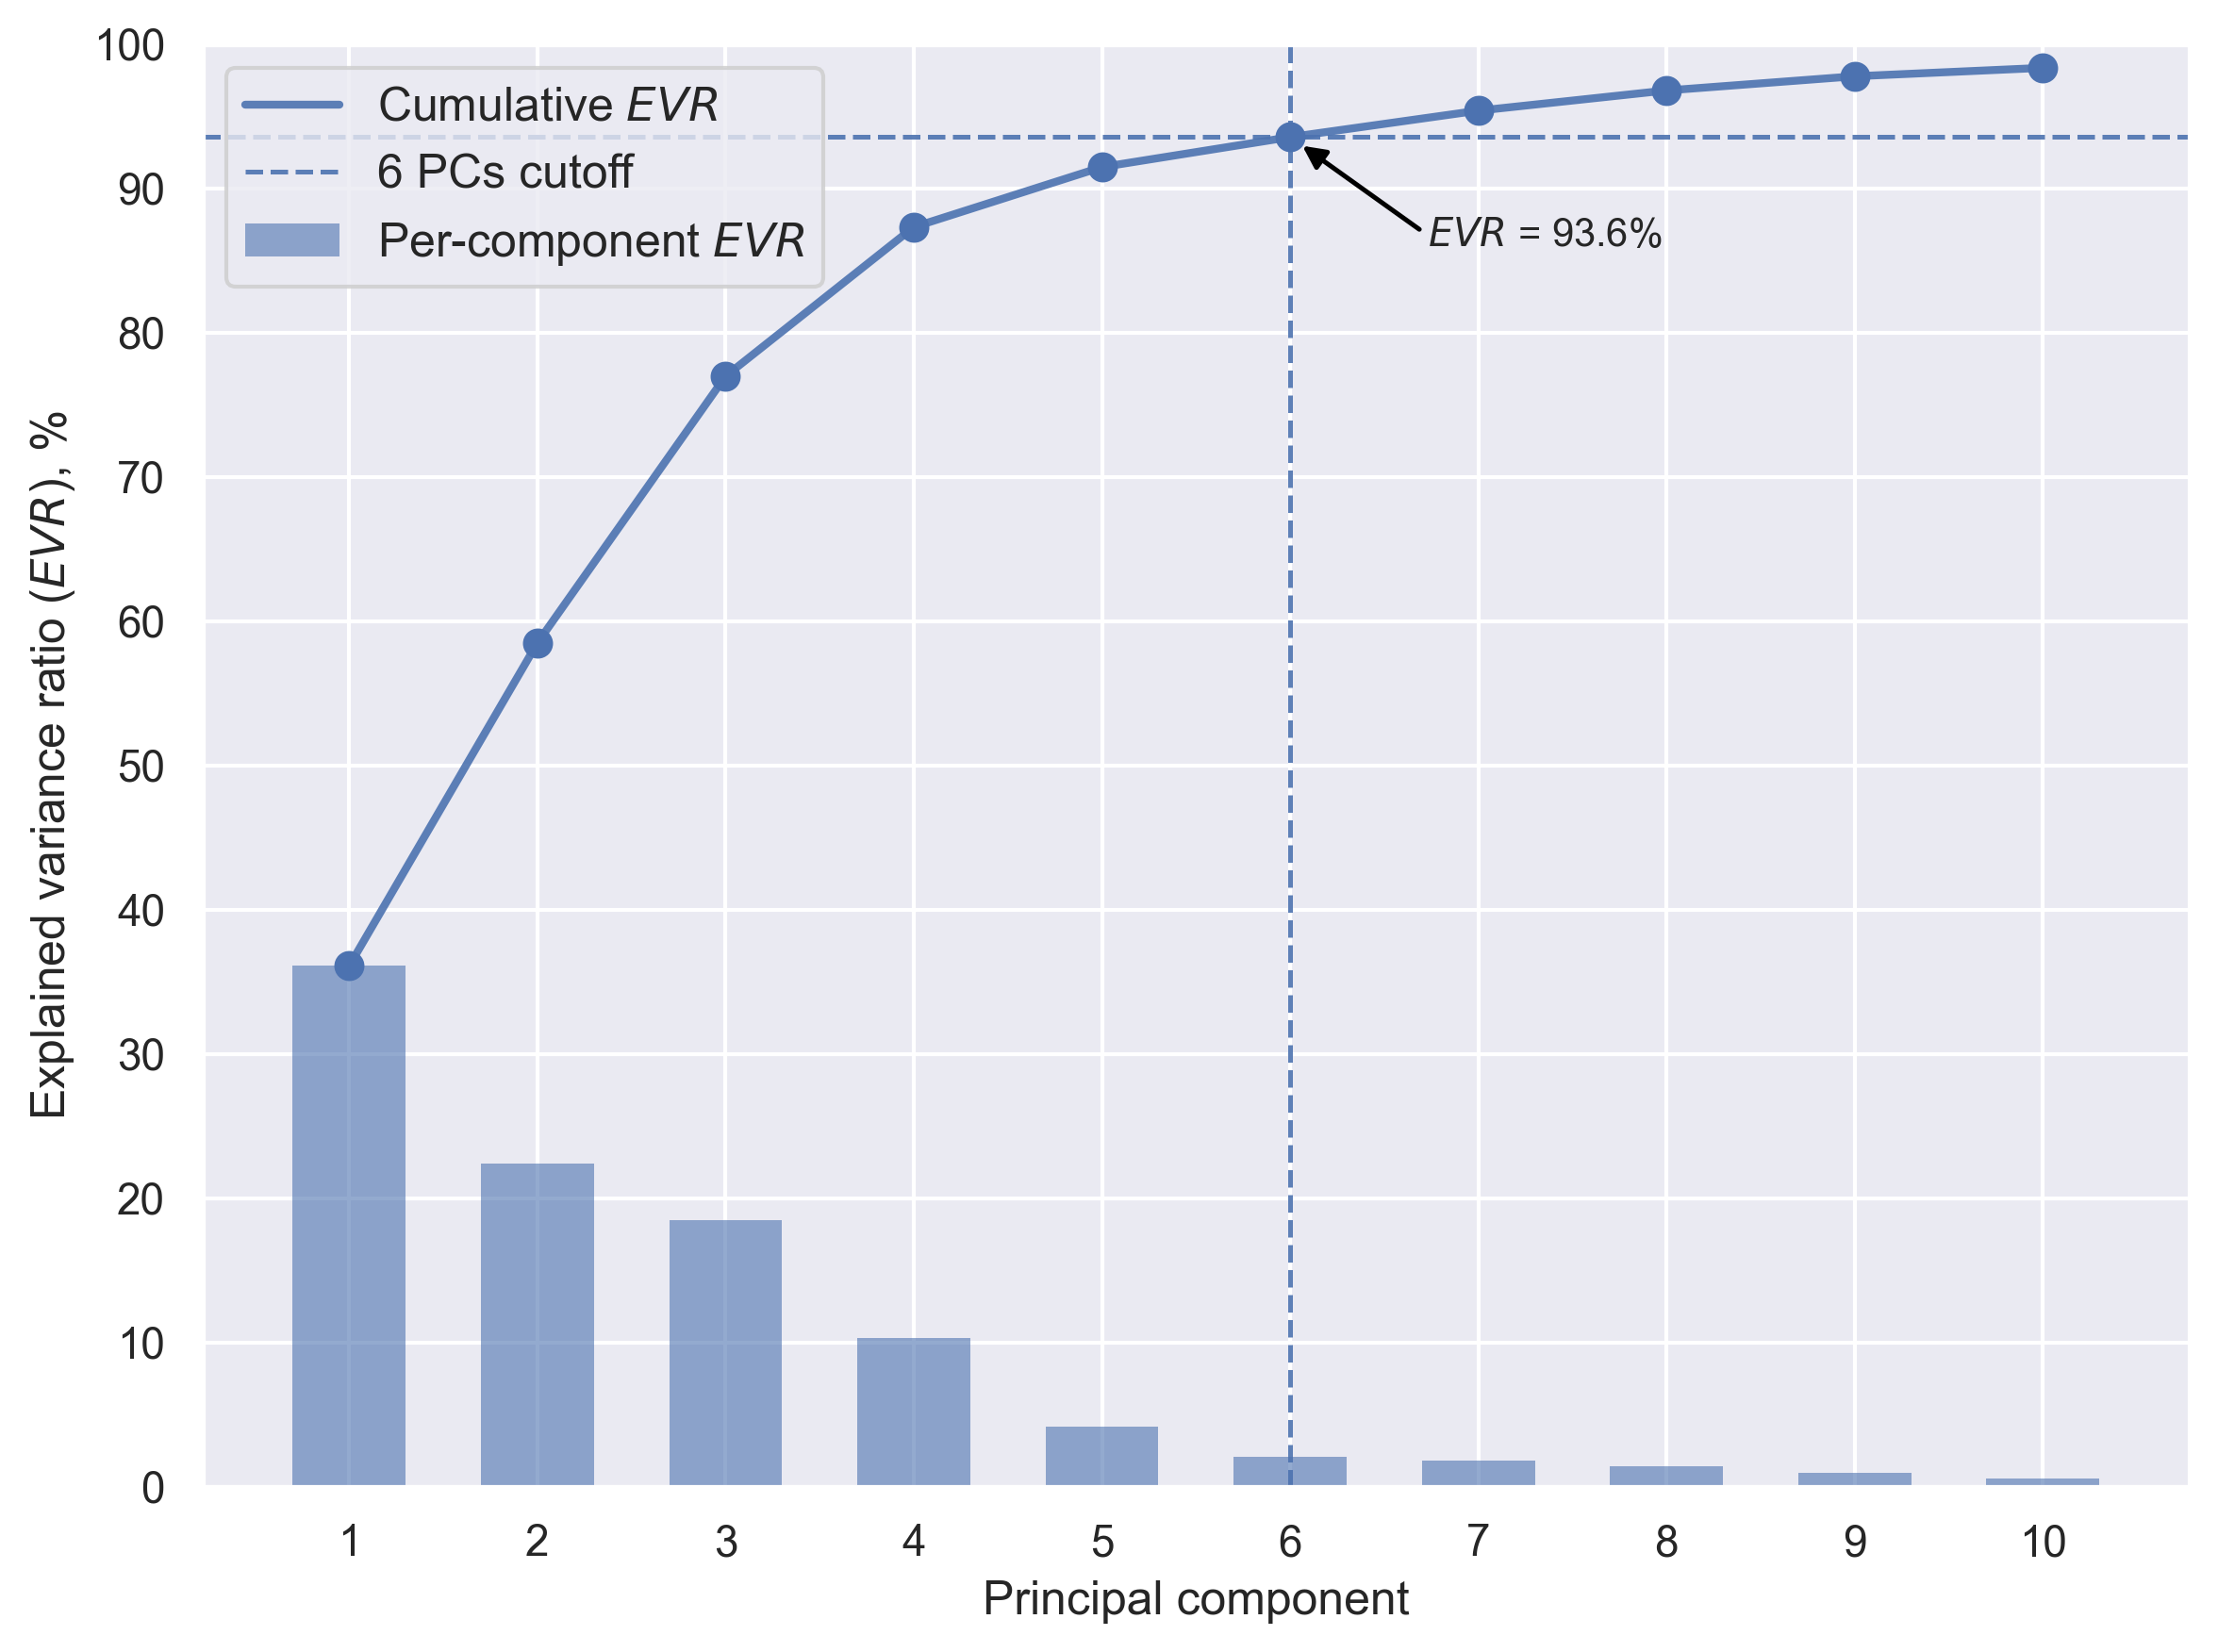

In [24]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

bar_face = mcolors.to_rgba('C0', alpha=0.6)
line_main = mcolors.to_rgba('C0', alpha=0.9)
line_cut  = mcolors.to_rgba('C3', alpha=0.9)

ax.bar(x, evr * 100, width=0.6, color=bar_face, edgecolor='none', label='Per-component $EVR$', zorder=2)

ax.plot(x, cum_evr, linewidth=2, color=line_main, label='Cumulative $EVR$', zorder=3)

ax.scatter(x, cum_evr, s=32, facecolor=mcolors.to_rgba('C0', 1.0), edgecolor=mcolors.to_rgba('C0', 1.0), linewidths=2.0, zorder=4)

# Радиус маркера в пунктах (pt) для shrinkB:
marker_size = 32
marker_edgewidth = 2.0
marker_radius_pts = 0.5 * np.sqrt(marker_size) + 0.5 * marker_edgewidth

if evr.size >= 6:
    k = 6
    ax.axvline(k, linestyle='--', linewidth=1.2, color=line_main,
               label=f'{k} PCs cutoff', zorder=1)
    ax.axhline(cum_evr[k-1], linestyle='--', linewidth=1.2, color=line_main, zorder=1)

    ax.annotate(
        f'$EVR$ = {cum_evr[k-1]:.1f}%',
        xy=(k, cum_evr[k-1]),
        xytext=(35, -25),   # текст сразу за стрелкой
        textcoords='offset points',
        ha='left', va='center',
        fontsize=10,
        arrowprops=dict(
            arrowstyle='-|>',
            color='black',
            lw=1.2,
            mutation_scale=12,
            shrinkA=0, shrinkB=marker_radius_pts,
            relpos=(0, 0.5)  # стрелка выходит прямо влево от текста
        ),
        annotation_clip=False
    )


ax.set_xlabel('Principal component')
ax.set_ylabel('Explained variance ratio ($EVR$), %')

ax.set_xticks(x)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylim(0, 100)
ax.legend(loc='upper left', frameon=True, fontsize=fontsize-2)

plt.tight_layout()

plt.savefig(f'{path_to_save}/lineplot_evr_on_npc.svg')

plt.show()

#### Selecting the top-*n* components

In [25]:
n_principal_components = 6

principal_components_df = pd.DataFrame(principal_components_all_df.iloc[:, :n_principal_components].to_numpy())

print(principal_components_df.shape)
principal_components_df.head(3)

(75, 6)


,0,1,2,3,4,5
0,6.193704,1.853621,-2.375375,2.377694,-0.659064,0.381487
1,7.848732,1.508956,-4.276829,-0.352333,-0.418396,-0.122660
2,5.580336,1.095111,-2.059692,2.070278,-0.968862,1.851787


### Optimization process

#### Data wrangling

RANDOM_STATE = 42
TEST_SIZE = 0.45 # 0.33, 0.40
N_TRIES = 250_000 # 100_000, 250_000, 1_000_000
METRIC = 'kl' # 'ks' или 'kl'

In [26]:
RANDOM_STATE = 42
TEST_SIZE = 0.33 # 0.33, 0.40
N_TRIES = 500_000 # 100_000, 250_000, 1_000_000
METRIC = 'kl' # 'ks' или 'kl'
KL_PARAMS = {
    'bins': 'fd',
    'min_bins': 5, # 5, 7
    'max_bins': 9, # 10, 12
    'prior': 0.5
}

In [27]:
X_scores = principal_components_df.values
y = np.asarray(target)

best_result = {
    'score': -np.inf,
    'train_idx': None,
    'test_idx': None,
    'iteration': None,
    'edges_list': None
}

In [28]:
%%time

sss = StratifiedShuffleSplit(
    n_splits=N_TRIES,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

splits = list(enumerate(sss.split(X_scores, y)))

CPU times: user 13.6 s, sys: 213 ms, total: 13.8 s
Wall time: 13.7 s


#### Optimization function

In [29]:
def eval_split(i, tr_idx, te_idx):
    if METRIC == 'kl':
        sim, details = split_similarity(
            tr_idx, te_idx, X_scores,
            n_pcs=X_scores.shape[1],
            metric='kl',
            kl_params=KL_PARAMS,
            return_details=True
        )
        edges_list = details.get('edges_list')
    else:
        sim, details = split_similarity(
            tr_idx, te_idx, X_scores,
            n_pcs=X_scores.shape[1],
            metric='ks',
            return_details=True
        )
        edges_list = None

    return {
        'score': sim,
        'train_idx': tr_idx,
        'test_idx': te_idx,
        'iteration': i,
        'edges_list': edges_list
    }

#### Analysis of results

In [30]:
%%time

with tqdm_joblib(desc="Calculation process", total=len(splits)):
    results = Parallel(
        n_jobs=-1,
        backend="loky",
        verbose=0
    )(
        delayed(eval_split)(i, tr_idx, te_idx)
        for i, (tr_idx, te_idx) in splits
    )

best_result = max(results, key=lambda d: d['score'])

Calculation process:   0%|          | 0/500000 [00:00<?, ?it/s]

CPU times: user 27.2 s, sys: 1.68 s, total: 28.9 s
Wall time: 29.4 s


In [31]:
train_idx = best_result['train_idx']
test_idx  = best_result['test_idx']

print(
    f'Best similarity score: {round(best_result["score"], 4)}',
    f'  – Train size: {len(train_idx)} | Test size: {len(test_idx)}',
    f'  – Train class counts: {pd.Series(target[train_idx]).value_counts().to_dict()}',
    f'  – Test class counts: {pd.Series(target[test_idx]).value_counts().to_dict()}',
    sep='\n'
)

Best similarity score: -0.0398
  – Train size: 50 | Test size: 25
  – Train class counts: {1: 20, 2: 15, 0: 15}
  – Test class counts: {1: 9, 0: 8, 2: 8}


### Saving *train/test* split in `samples_description`

In [32]:
samples_description_split = samples_description.copy()

print(samples_description_split.shape)
samples_description_split.head(3)

(75, 6)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1


In [33]:
samples_description_split["Split"] = "Unknown"

samples_description_split.iloc[train_idx, samples_description_split.columns.get_loc("Split")] = "Train"
samples_description_split.iloc[test_idx,  samples_description_split.columns.get_loc("Split")] = "Test"

print(samples_description_split.shape)
samples_description_split.head(3)

(75, 7)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class,Split
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2,Train
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1,Test
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1,Train


In [34]:
pd.DataFrame(samples_description_split['Split'].value_counts()).T

Split,Train,Test
count,50,25


In [35]:
pd.DataFrame(samples_description_split[['Split', 'Fraction_grouped_hue']].value_counts()).T

Split                         Train                              Test          \
Fraction_grouped_hue $2 < d \leq 5$ $d > 5$ $d \leq 2$ $2 < d \leq 5$ $d > 5$   
count                            20      15         15              9       8   

Split                            
Fraction_grouped_hue $d \leq 2$  
count                         8

## Visualization of processed data

In [36]:
data = pd.DataFrame(principal_components_df.copy())

data['Type'] = np.array(hue)
data['Label'] = 'Test'
data.loc[train_idx, 'Label'] = 'Train'

model_factors = principal_components_df.columns.tolist()

In [37]:
fontsize = 14

unique_types = list(type_color_dict.keys())
palette = type_color_dict.copy()
marker_dict = {'Train': 'o', 'Test': 'D'}
alpha_dict = {'Train': 1.0, 'Test': 0.75}
# size_dict = {'Train': 200, 'Test': 400}

### Principal components

#### 2 PCs (1 subplot)

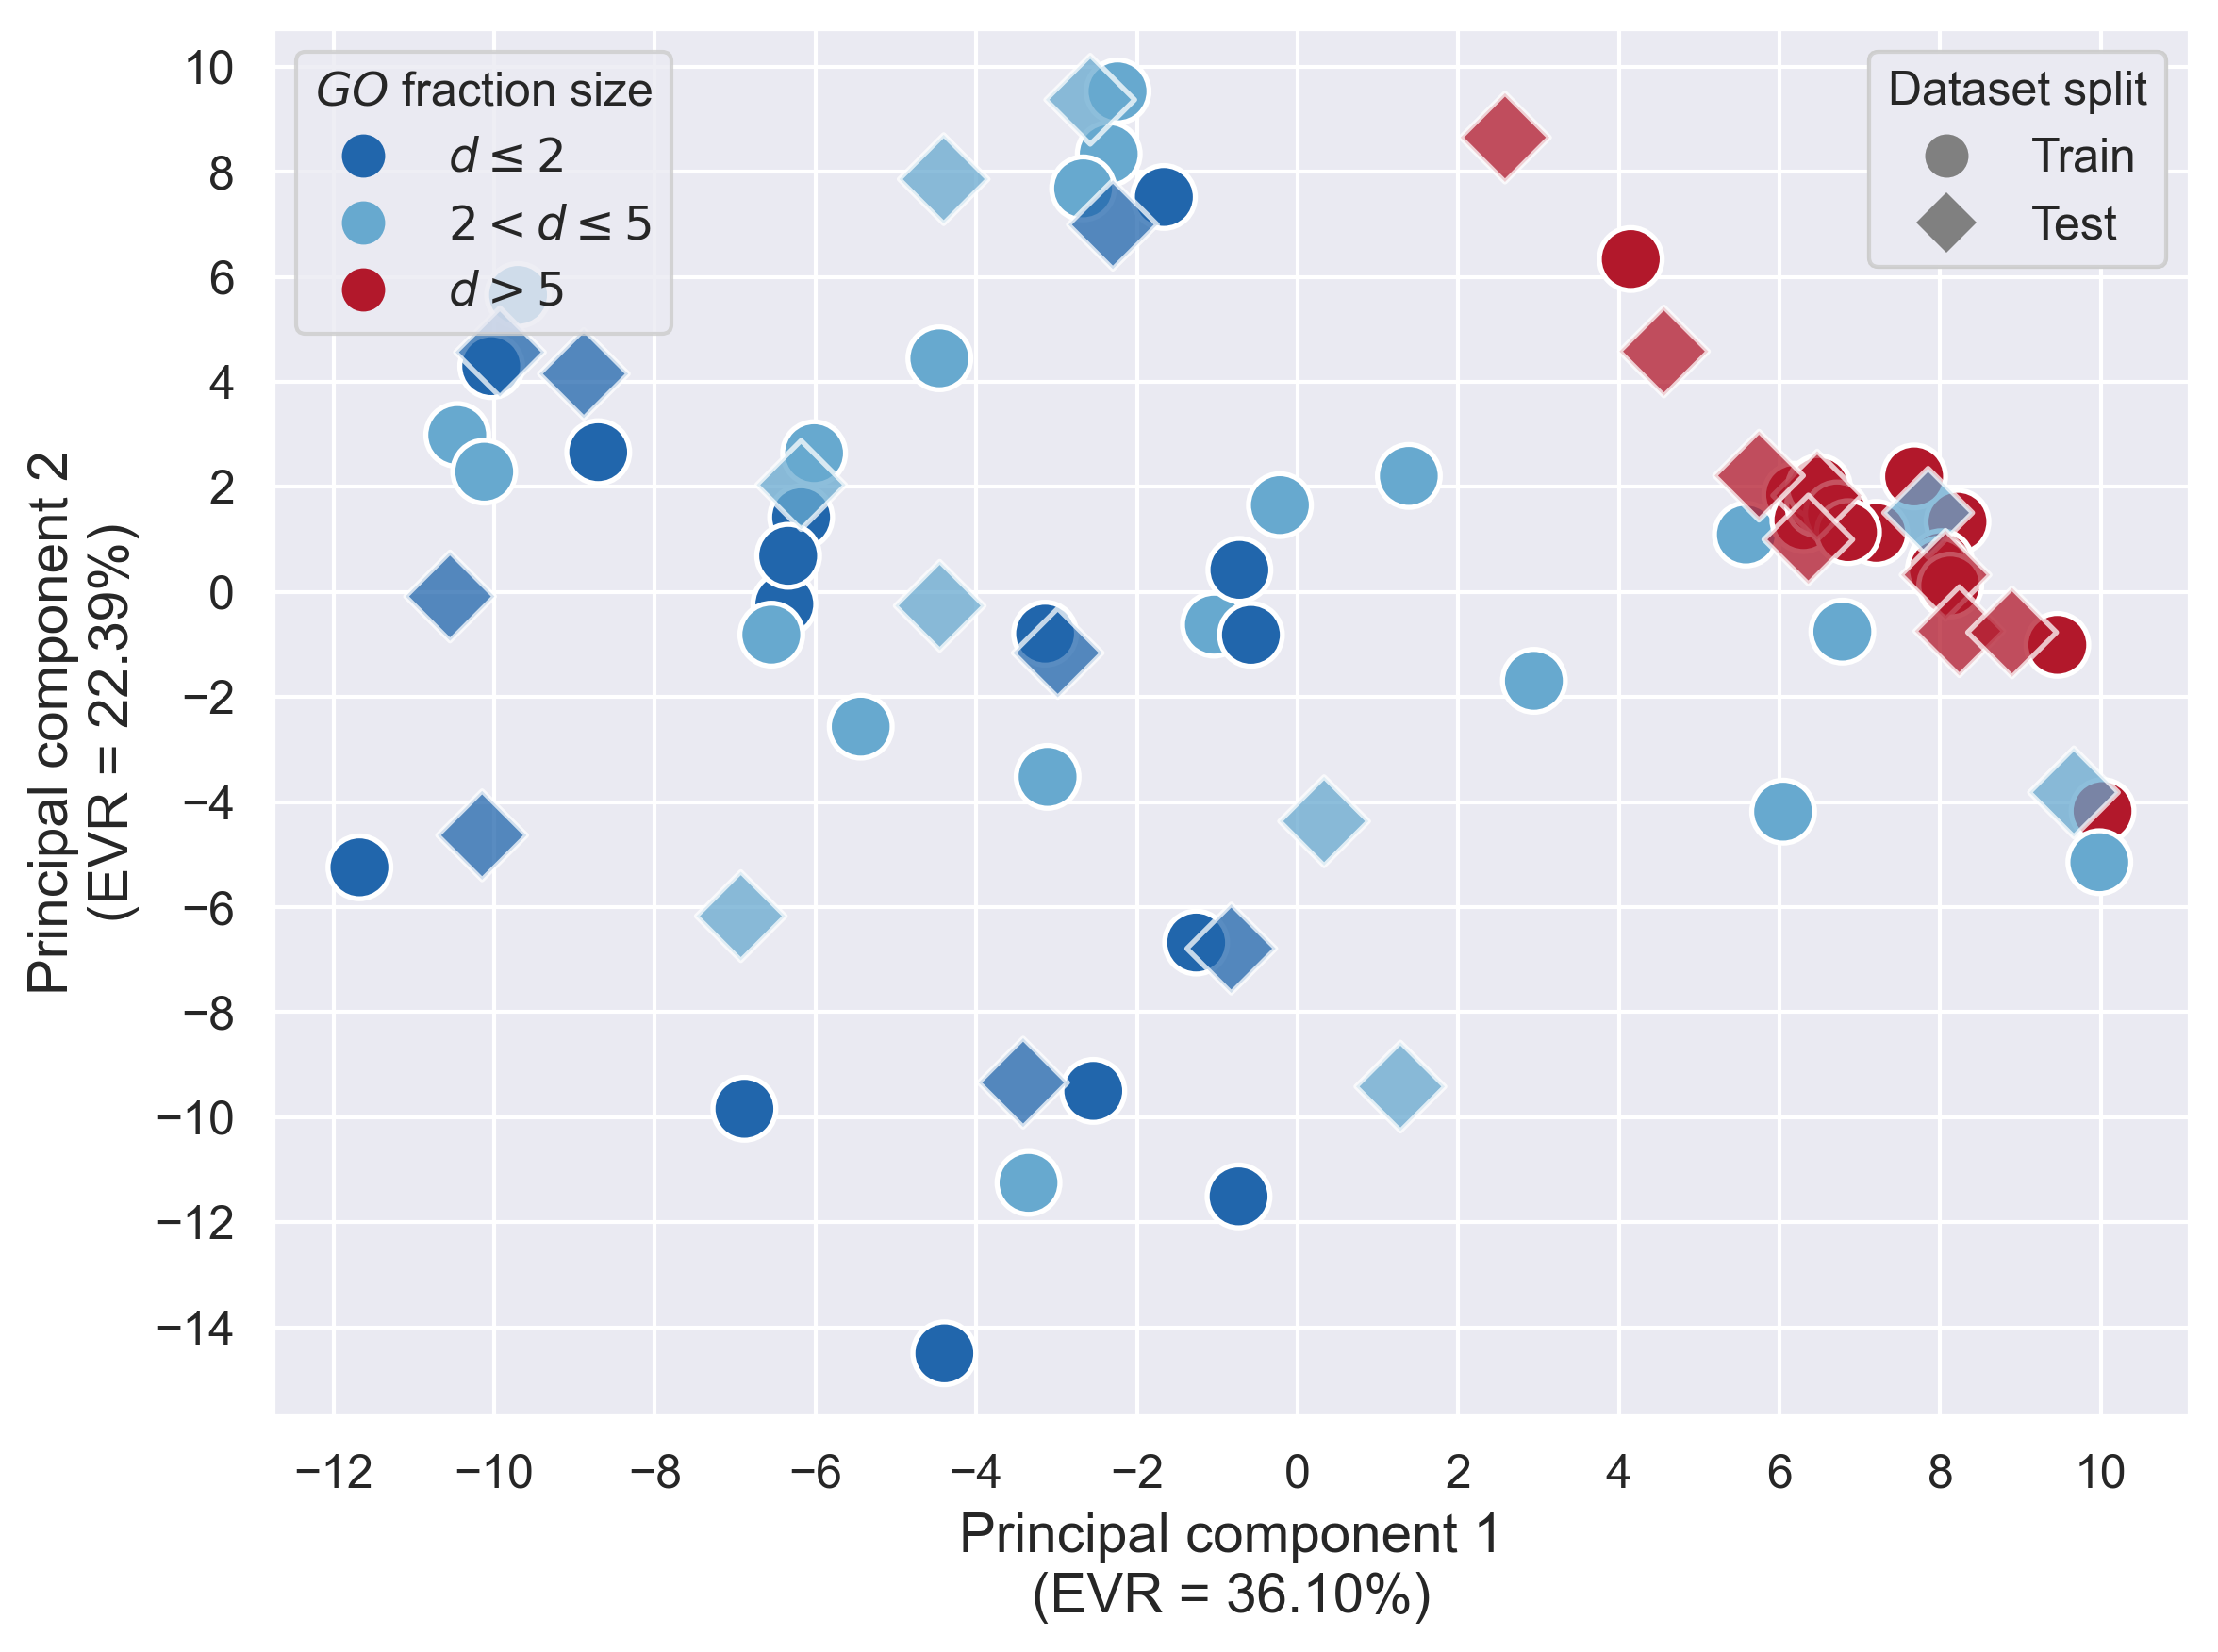

In [38]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

for label in data['Label'].unique():
    subset = data[data['Label'] == label]
    sns.scatterplot(
        data=subset,
        x=model_factors[0],
        y=model_factors[1],
        hue=subset["Type"],
        palette=palette,
        s=256,
        style=subset["Label"],
        markers=marker_dict,
        # size=subset["Label"].map(size_dict),
        # sizes=(min(size_dict.values()), max(size_dict.values())),
        alpha=alpha_dict[label],
        ax=ax,
        legend=False
    )

ax.set_ylabel(f"Principal component 2\n(EVR = {explained_variance_lst[1] * 100:.2f}%)", fontsize=fontsize)
ax.set_xlabel(f"Principal component 1\n(EVR = {explained_variance_lst[0] * 100:.2f}%)", fontsize=fontsize)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.tick_params(axis='both', which='major', labelsize=fontsize - 2)

# Legend for sample type hue
handles_hue = [
    plt.Line2D([0], [0], color=palette[type_], marker='o', linestyle='', markersize=10)
    for type_ in unique_types
]
legend_hue = ax.legend(
    handles_hue,
    unique_types,
    title="$GO$ fraction size",
    loc='upper left',
    fontsize=fontsize - 2,
    title_fontsize=fontsize - 2
)

# Legend for Train/Test hue
handles_label = [
    plt.Line2D([0], [0], color='gray', marker=marker_dict[label], linestyle='', markersize=10)
    for label in ['Train', 'Test']
]
legend_label = ax.legend(
    handles_label,
    ['Train', 'Test'],
    title="Dataset split",
    loc='upper right',
    fontsize=fontsize - 2,
    title_fontsize=fontsize - 2
)

ax.add_artist(legend_hue)
ax.add_artist(legend_label)

plt.tight_layout()

plt.savefig(f'{path_to_save}/scatterplot_pc_2d.svg')

plt.show()

#### 6 PCs (3 subplots)

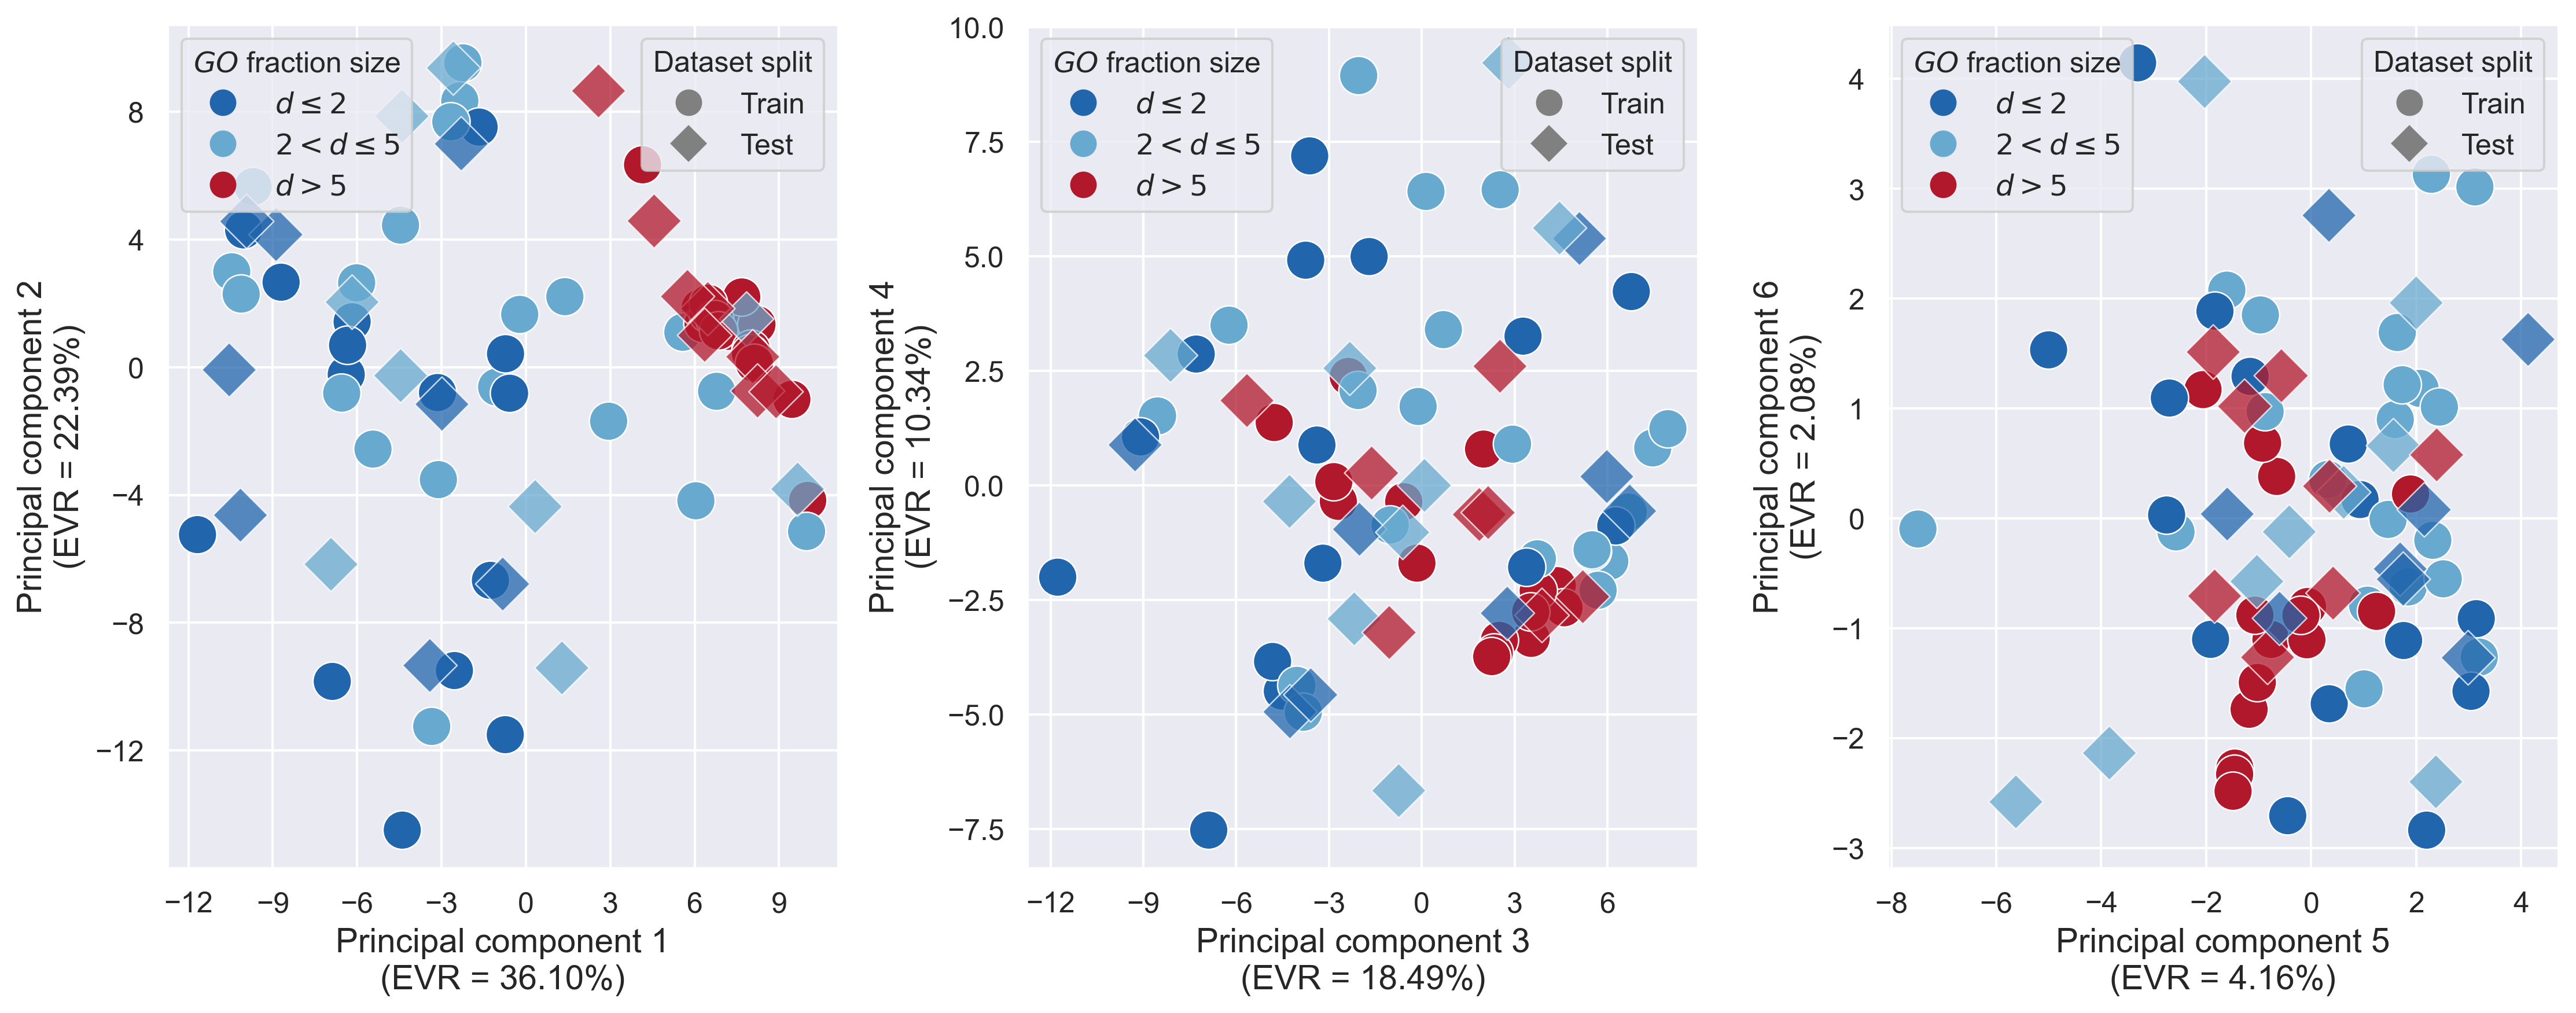

In [39]:
pairs = [(0, 1), (2, 3), (4, 5)]  # (PC1,PC2), (PC3,PC4), (PC5,PC6)
type_order  = list(unique_types)   # или зафиксируйте свой порядок
label_order = ['Train', 'Test']    # порядок для маркеров

fig, axes = plt.subplots(1, len(pairs), figsize=(15, 6), dpi=300)

if len(pairs) == 1:
    axes = [axes]

for ax, (i, j) in zip(axes, pairs):
    # 1) Рисуем по слоям Label, чтобы задать маркеры и alpha
    for lbl in label_order:
        subset = data[data['Label'] == lbl]
        sns.scatterplot(
            data=subset,
            x=model_factors[i],
            y=model_factors[j],
            hue="Type",                # цвета по типу
            hue_order=type_order,
            palette=palette,
            marker=marker_dict[lbl],   # фиксируем маркер для этого слоя
            s=256,
            alpha=alpha_dict[lbl],
            edgecolor='white', linewidth=0.6,
            legend=False,              # отключаем авто‑легенды
            ax=ax
        )

    # Оси и подписи с EVR
    ax.set_xlabel(f"Principal component {i+1}\n(EVR = {explained_variance_lst[i]*100:.2f}%)", fontsize=fontsize)
    ax.set_ylabel(f"Principal component {j+1}\n(EVR = {explained_variance_lst[j]*100:.2f}%)", fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize - 2)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(8))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(8))

    # 2) Легенда по hue (цветам)
    hue_handles = [
        Line2D([0],[0], marker='o', linestyle='', markersize=10,
               color=palette[t], markerfacecolor=palette[t], markeredgecolor=palette[t])
        for t in type_order
    ]
    leg_hue = ax.legend(
        hue_handles, [str(t) for t in type_order],
        title="$GO$ fraction size",
        loc='upper left',
        fontsize=fontsize - 2, title_fontsize=fontsize - 2, frameon=True
    )

    # 3) Легенда по style (маркерам)
    style_handles = [
        Line2D([0],[0], marker=marker_dict[lbl], linestyle='', markersize=10,
               color='gray', markerfacecolor='gray', markeredgecolor='gray')
        for lbl in label_order
    ]
    leg_style = ax.legend(
        style_handles, label_order,
        title="Dataset split",
        loc='upper right',
        fontsize=fontsize - 2, title_fontsize=fontsize - 2, frameon=True
    )

    ax.add_artist(leg_hue)  # чтобы первая легенда не была перезаписана второй

plt.tight_layout()

plt.savefig(f'{path_to_save}/scatterplot_pc_pairs.svg')

plt.show()

####  KS-test *p-values* bar plot

In [40]:
n_pcs = len(principal_components_df.columns)
pcs   = list(principal_components_df.columns[:n_pcs])

pvals = []
for i, pc in enumerate(pcs, start=1):
    train_vals = data.loc[data['Label'] == 'Train', pc].dropna().to_numpy()
    test_vals  = data.loc[data['Label'] == 'Test',  pc].dropna().to_numpy()
    p = ks_similarity_1d(train_vals=train_vals, test_vals=test_vals)
    pvals.append(p)

In [41]:
fontsize = 14

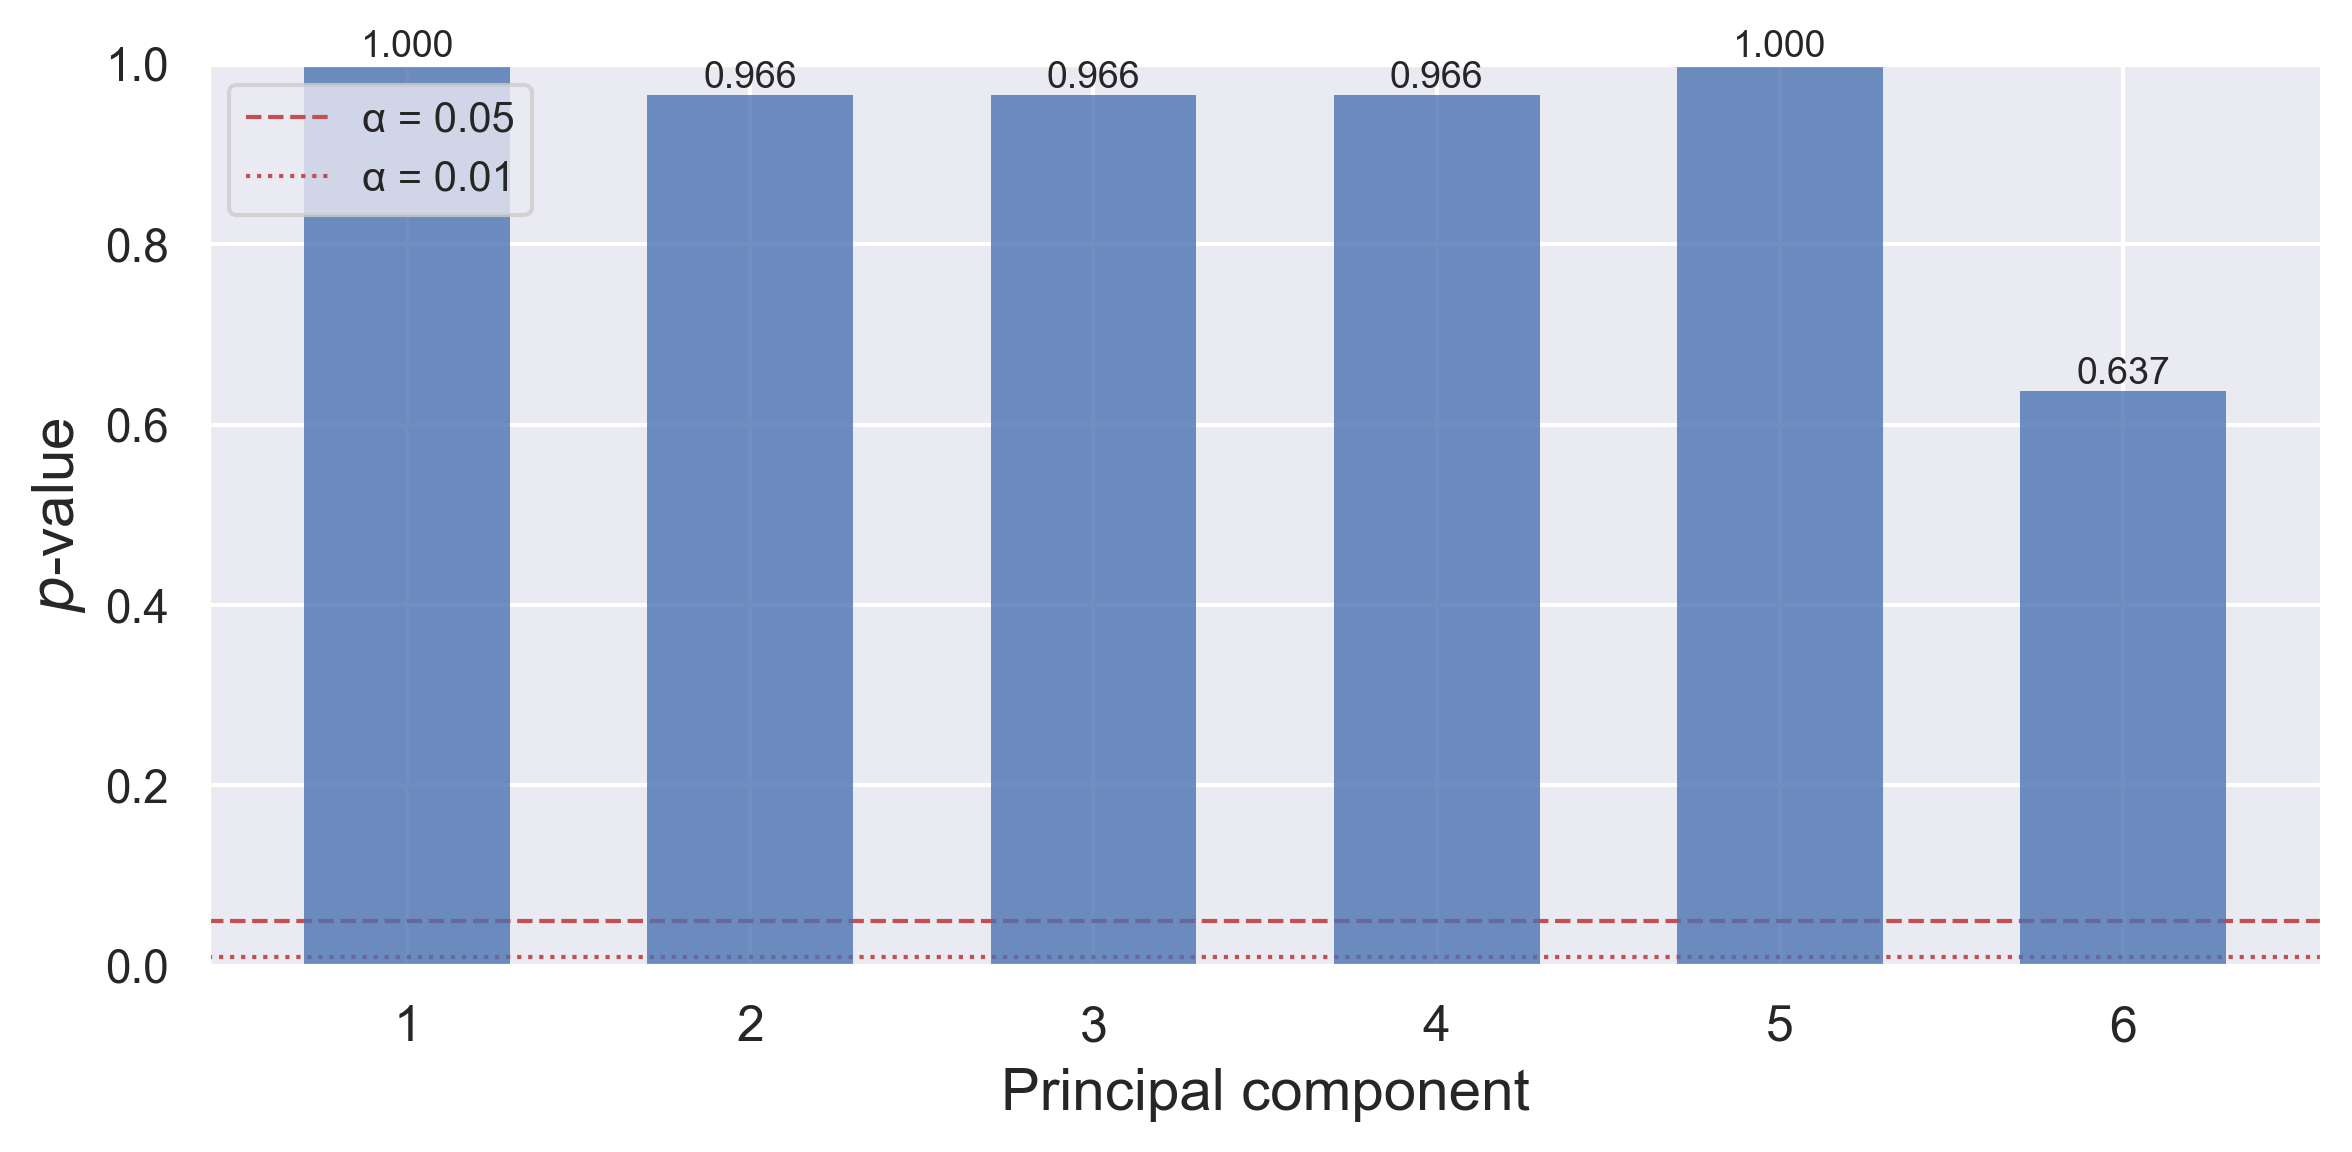

In [54]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

x = np.arange(1, n_pcs + 1)

bars = ax.bar(x, pvals, width=0.6, color='C0', alpha=0.8, edgecolor='none', label='', zorder=2)

ax.axhline(0.05, linestyle='--', linewidth=1, color='C3', label='α = 0.05', zorder=1)
ax.axhline(0.01, linestyle=':',  linewidth=1, color='C3', label='α = 0.01', zorder=1)

ax.set_xlabel('Principal component', fontsize=fontsize)
ax.set_ylabel('$p$-value', fontsize=fontsize)

ax.set_xticks(x)
ax.set_xticklabels([f'{i}' for i in x], fontsize=fontsize-2)

ax.set_ylim(0, 1.0)

ax.legend(frameon=True, loc='upper left', fontsize=fontsize-4)

for xi, p, b in zip(x, pvals, bars):
    txt = f'{p:.3f}' if p >= 0.001 else f'{p:.1e}'
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.00, txt,
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()

plt.savefig(f'{path_to_save}/ks_pvalues_barplot.svg')

plt.show()

### Histograms of principal components

In [43]:
HISTTYPE   = 'bar'   # 'stepfilled' | 'step' | 'bar'
NORMALIZE  = 'pdf'      # 'count' | 'pdf' | 'percent'
PAIRS      = ('Train', 'Test')
COLORS     = ('C0', 'C3')
ALPHA_FILL = 0.75           # прозрачность заливки (для 'step' не используется)
FIGSIZE    = (15, 6)
FONTSIZE   = 14

In [44]:
n_pcs_all = len(best_result["edges_list"])
n_pcs     = min(6, n_pcs_all, len(data.columns))  # показываем максимум 6
pcs       = list(data.columns[:n_pcs])

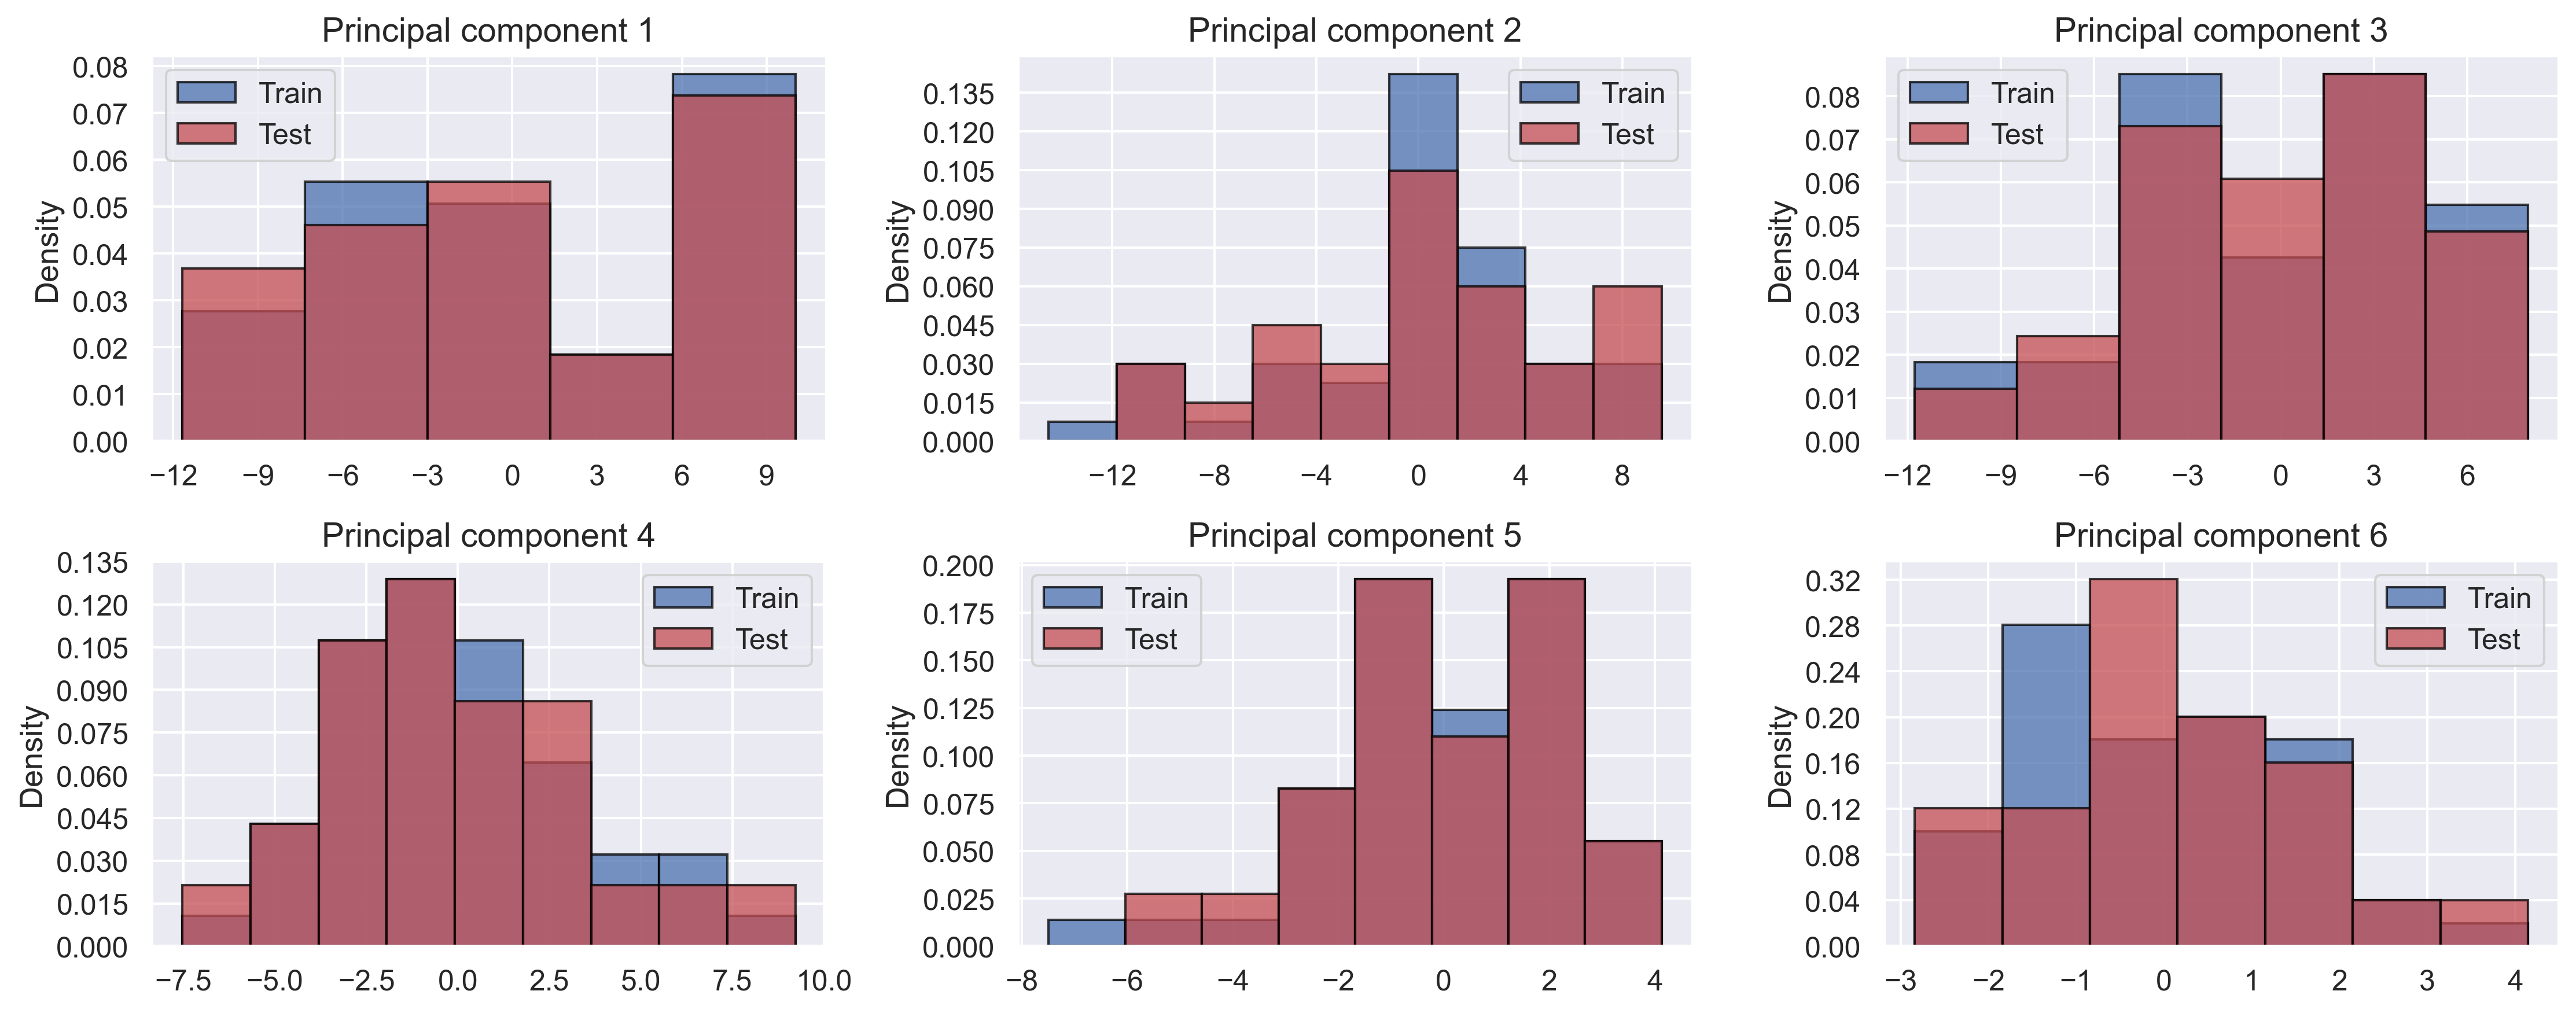

In [45]:
fig, axes = plt.subplots(2, 3, figsize=FIGSIZE, dpi=300)
axes = axes.flatten()

if NORMALIZE == 'count':
    y_label = "Count"
elif NORMALIZE == 'pdf':
    y_label = "Density"
elif NORMALIZE == 'percent':
    y_label = "Percent (%)"
else:
    raise ValueError("NORMALIZE must be 'count', 'pdf', or 'percent'")

for ax, i, pc in zip(axes, range(n_pcs), pcs):
    edges = best_result["edges_list"][i]  # фиксируем те же бины, что в KL

    for lbl, col in zip(PAIRS, COLORS):
        vals = data.loc[data["Label"] == lbl, pc].dropna().to_numpy()

        # --- нормализация ---
        if NORMALIZE == 'count':
            density = False
            weights = None
        elif NORMALIZE == 'pdf':
            density = True
            weights = None
        elif NORMALIZE == 'percent':
            density = False
            weights = None if len(vals) == 0 else np.ones_like(vals) * (100.0 / len(vals))

        ax.hist(
            vals,
            bins=edges,
            histtype=HISTTYPE,
            color=col,
            alpha=ALPHA_FILL if HISTTYPE != 'step' else 1.0,
            linewidth=1.0,
            edgecolor='black' if HISTTYPE != 'step' else col,
            weights=weights,
            density=density,
            label=lbl,
        )

    ax.set_title(f"Principal component {pc+1}", fontsize=FONTSIZE)
    
    ax.set_ylabel(y_label, fontsize=FONTSIZE-1)
    ax.tick_params(axis='both', which='major', labelsize=fontsize - 2)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(8))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax.legend(fontsize=FONTSIZE-2, frameon=True)

for j in range(n_pcs, 6):
    fig.delaxes(axes[j])

if NORMALIZE == 'percent':
    for ax in axes[:n_pcs]:
        ax.set_ylim(0, 100)

plt.tight_layout()

plt.savefig(f'{path_to_save}/histograms_pc_2x3.svg')

plt.show()

### Box plot

In [46]:
CFG = dict(
    PAIRS=('Train', 'Test'),
    COLORS=('C0', 'C3'),
    FIGSIZE=(15, 6),
    FONTSIZE=14,
    ORIENT='v',
    SHOW_FLIERS=True,
    WHIS=(5, 95),
    NOTCHED=False,
    ADD_STRIP=True,
    POINT_SIZE=8,
    STRIP_ALPHA=0.6,
    BOX_LINEWIDTH=0.5,
    NBINS_CONT=10,
)

n_pcs = min(6, len(best_result["edges_list"]), len(data.columns))
pcs   = list(data.columns[:n_pcs])

palette_box = dict(zip(CFG['PAIRS'], CFG['COLORS']))

box_kwargs = dict(
    palette=palette_box, whis=CFG['WHIS'], showcaps=True,
    showfliers=CFG['SHOW_FLIERS'], notch=CFG['NOTCHED'],
    width=0.6, linewidth=CFG['BOX_LINEWIDTH'],
    boxprops=dict(linewidth=CFG['BOX_LINEWIDTH']),
    medianprops=dict(linewidth=CFG['BOX_LINEWIDTH'] + 0.4),
    whiskerprops=dict(linewidth=CFG['BOX_LINEWIDTH']),
    capprops=dict(linewidth=CFG['BOX_LINEWIDTH']),
    flierprops=dict(marker='o', markersize=3, markerfacecolor='gray', alpha=0.6),
)

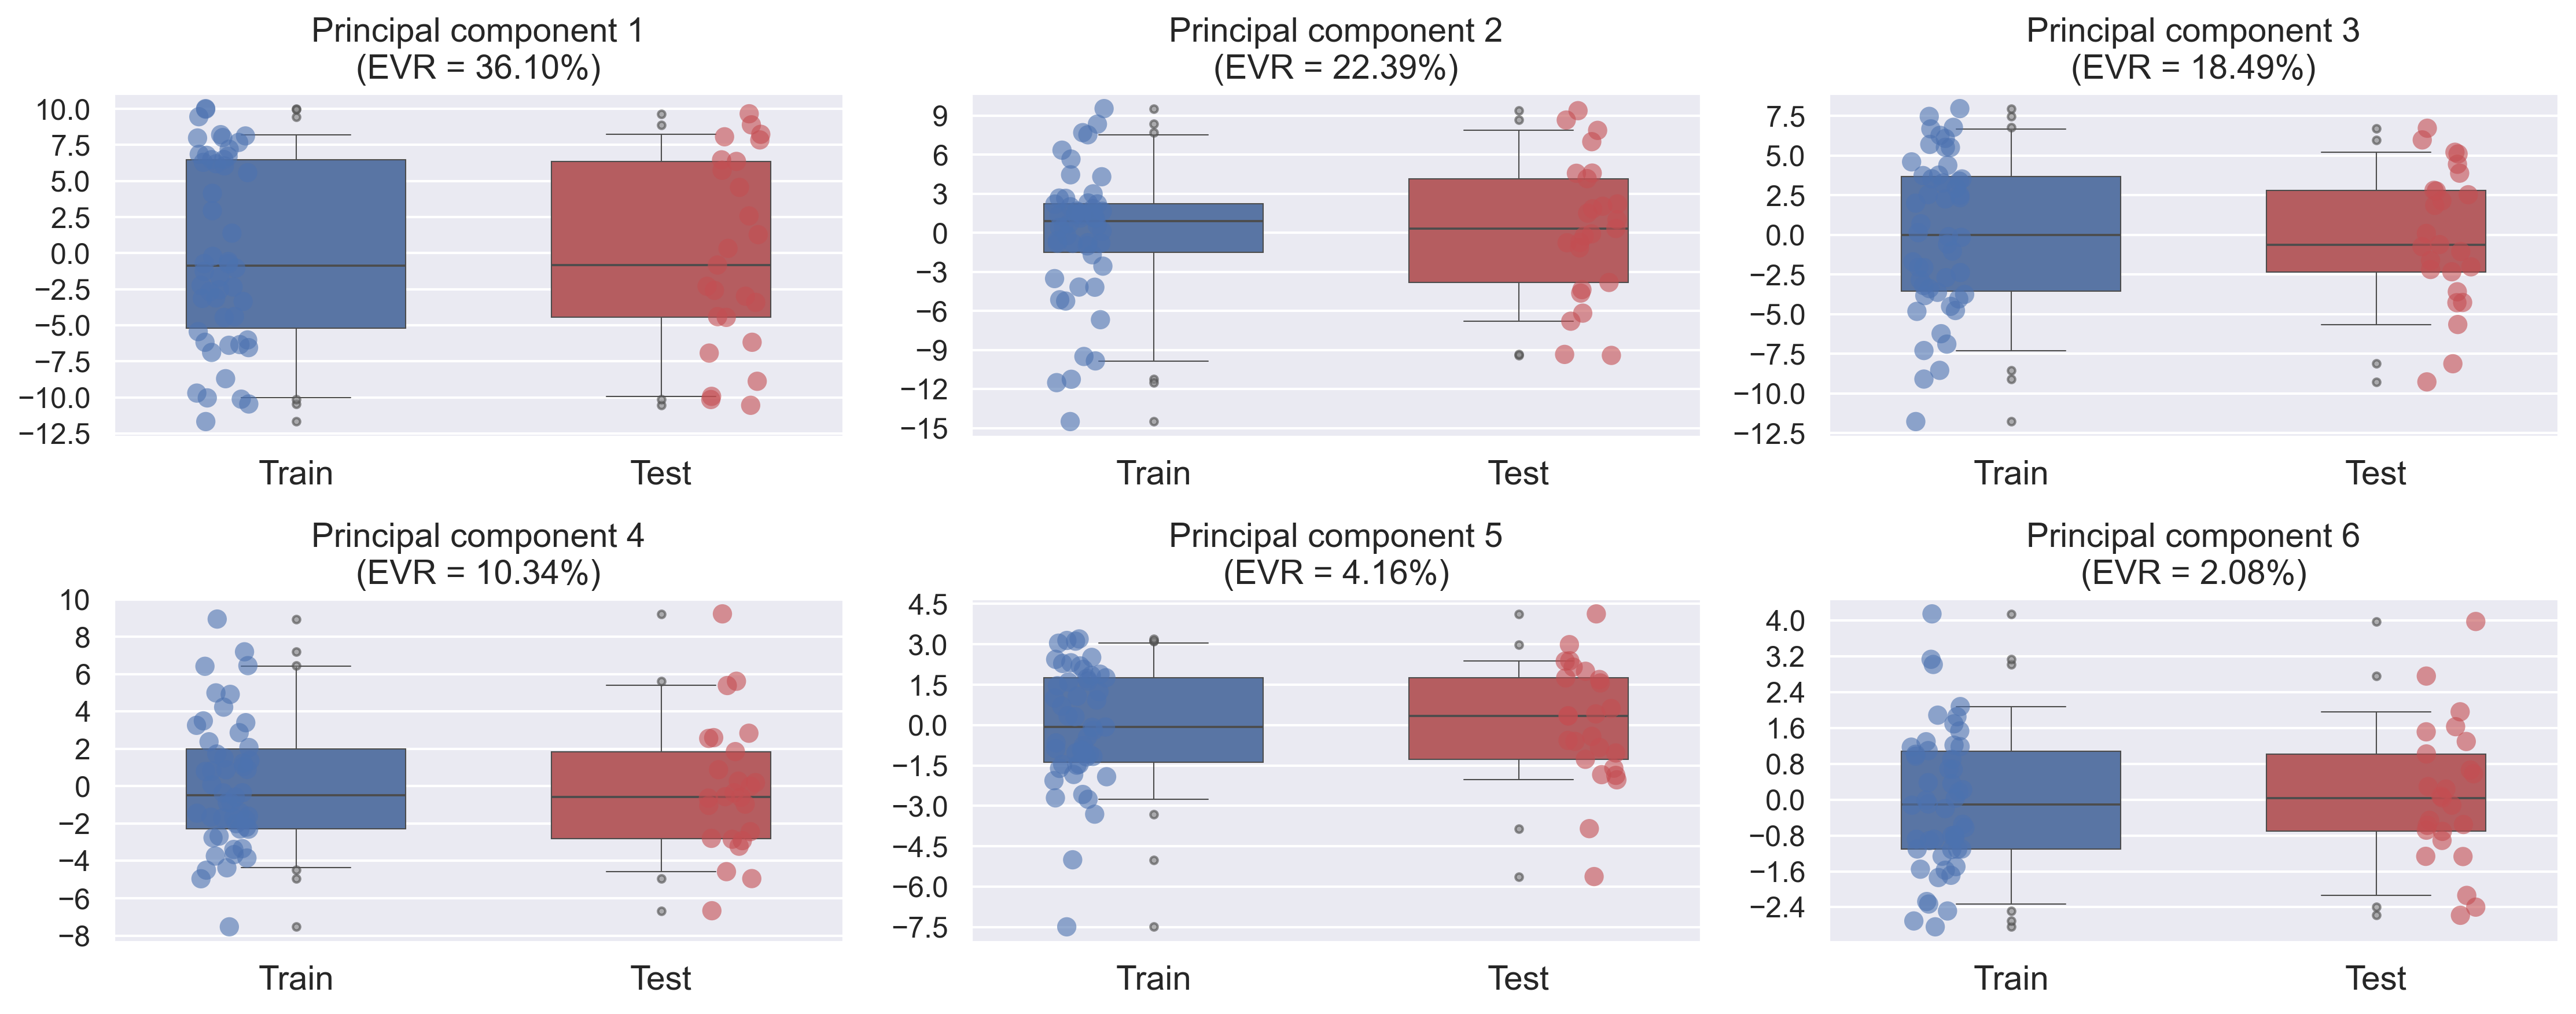

In [47]:
fig, axes = plt.subplots(2, 3, figsize=CFG['FIGSIZE'], dpi=300)
axes = axes.flatten()

for ax, i, pc in zip(axes, range(n_pcs), pcs):
    sub = data[['Label', pc]].dropna().copy()
    sub['Label'] = pd.Categorical(sub['Label'], categories=list(CFG['PAIRS']), ordered=True)

    if CFG['ORIENT'] == 'v':
        x_key, y_key = 'Label', pc
        grid_axis = 'y'
        cont_axis = ax.yaxis
        cat_axis  = ax.xaxis
    else:
        x_key, y_key = pc, 'Label'
        grid_axis = 'x'
        cont_axis = ax.xaxis
        cat_axis  = ax.yaxis

    sns.boxplot(data=sub, x=x_key, y=y_key, order=CFG['PAIRS'], ax=ax, **box_kwargs)

    if CFG['ADD_STRIP']:
        sns.stripplot(
            data=sub, x=x_key, y=y_key, order=CFG['PAIRS'],
            hue='Label', palette=palette_box, dodge=True, jitter=0.15,
            size=CFG['POINT_SIZE'], alpha=CFG['STRIP_ALPHA'],
            linewidth=0, legend=False, ax=ax
        )

    ax.set_title(f"Principal component {i+1}\n(EVR = {explained_variance_lst[i]*100:.2f}%)", fontsize=CFG['FONTSIZE'])
    ax.set_xlabel("")
    ax.set_ylabel("")

    cat_axis.set_tick_params(labelsize=CFG['FONTSIZE'])
    cont_axis.set_tick_params(labelsize=CFG['FONTSIZE'] - 2)
    cont_axis.set_major_locator(ticker.MaxNLocator(nbins=CFG['NBINS_CONT']))

for j in range(n_pcs, 6):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.savefig(f'{path_to_save}/boxplots_pc_2x3.svg')

plt.show()

### Violin plot

In [48]:
CFG = dict(
    PAIRS=('Train', 'Test'),
    COLORS=('C0', 'C3'),
    FIGSIZE=(15, 6),
    FONTSIZE=14,
    ORIENT='v',          # 'v' — вертикаль, 'h' — горизонталь
    SCALE='width',       # 'width', 'count', 'area'
    INNER='box',         # 'box', 'point', 'quartile', None
    BW=0.3,               # ширина сглаживания
    CUT=0,               # обрезка по экстремумам данных
    ADD_STRIP=False,
    POINT_SIZE=6,
    STRIP_ALPHA=0.4,
    NBINS_CONT=10
)

n_pcs = min(6, len(best_result["edges_list"]), len(data.columns))
pcs   = list(data.columns[:n_pcs])

palette_violin = dict(zip(CFG['PAIRS'], CFG['COLORS']))

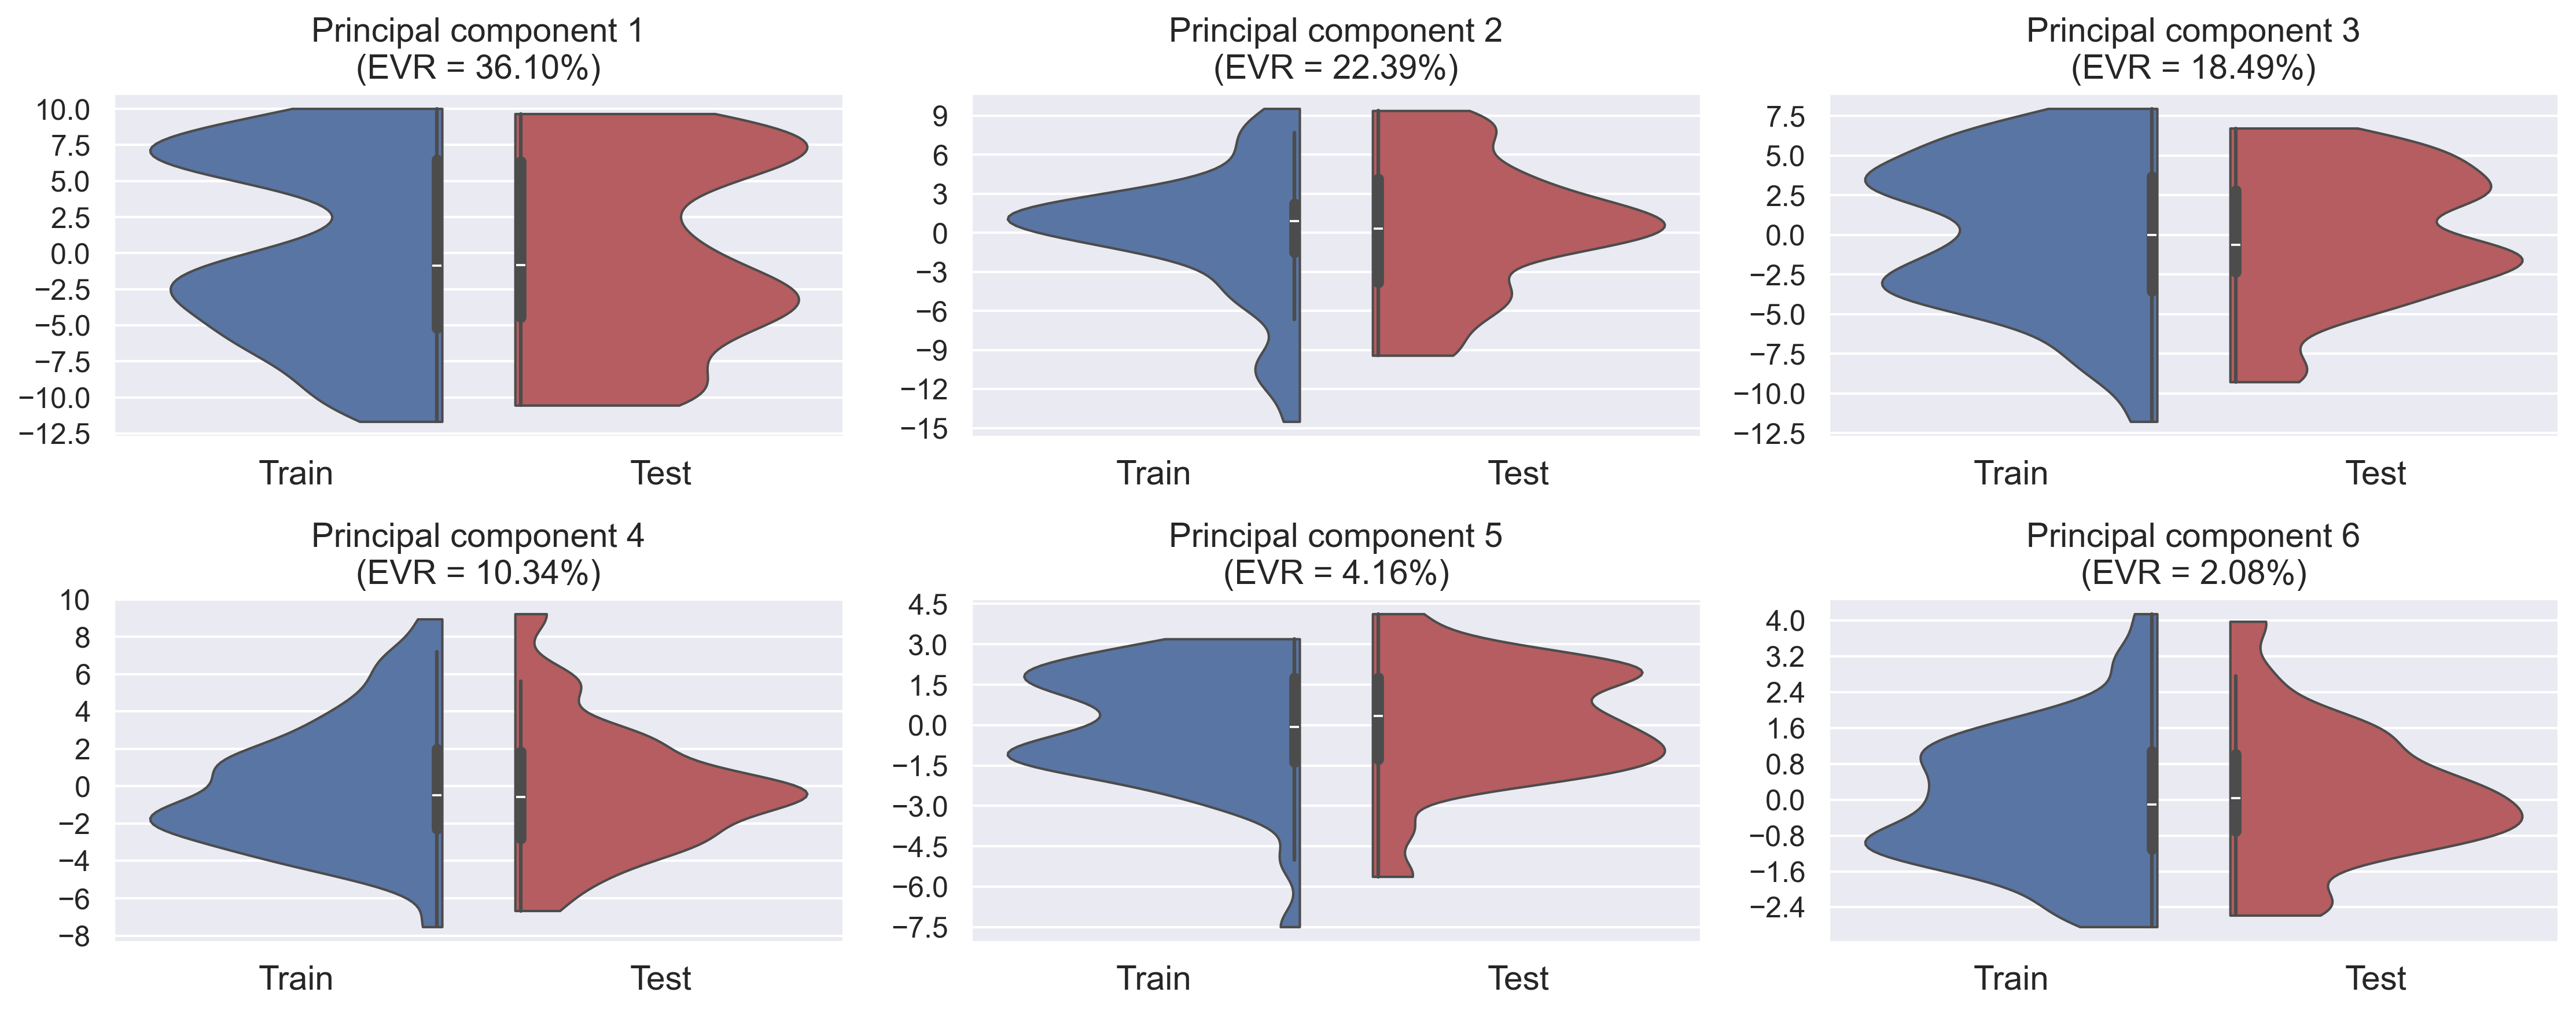

In [49]:
fig, axes = plt.subplots(2, 3, figsize=CFG['FIGSIZE'], dpi=300)
axes = axes.flatten()

for ax, i, pc in zip(axes, range(n_pcs), pcs):
    sub = data[['Label', pc]].dropna().copy()
    sub['Label'] = pd.Categorical(sub['Label'], categories=list(CFG['PAIRS']), ordered=True)

    if CFG['ORIENT'] == 'v':
        x_key, y_key = 'Label', pc
        grid_axis = 'y'
        cont_axis, cat_axis = ax.yaxis, ax.xaxis
    else:
        x_key, y_key = pc, 'Label'
        grid_axis = 'x'
        cont_axis, cat_axis = ax.xaxis, ax.yaxis

    sns.violinplot(
        data=sub, x=x_key, y=y_key, hue='Label', order=CFG['PAIRS'],
        palette=palette_violin, split=True,
        scale=CFG['SCALE'], inner=CFG['INNER'], bw=CFG['BW'], cut=CFG['CUT'],
        linewidth=1.0, ax=ax
    )

    if CFG['ADD_STRIP']:
        sns.stripplot(
            data=sub, x=x_key, y=y_key, hue='Label', order=CFG['PAIRS'],
            palette=palette_violin, dodge=True,
            size=CFG['POINT_SIZE'], alpha=CFG['STRIP_ALPHA'],
            jitter=0.15, linewidth=0, legend=False, ax=ax
        )

    ax.set_title(f"Principal component {i+1}\n(EVR = {explained_variance_lst[i]*100:.2f}%)", fontsize=CFG['FONTSIZE'])
    ax.set_xlabel("")
    ax.set_ylabel("")

    cat_axis.set_tick_params(labelsize=CFG['FONTSIZE'])
    cont_axis.set_tick_params(labelsize=CFG['FONTSIZE'] - 2)
    cont_axis.set_major_locator(ticker.MaxNLocator(nbins=CFG['NBINS_CONT']))

for j in range(n_pcs, 6):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.savefig(f'{path_to_save}/violinplots_pc_2x3.svg')

plt.show()

# Saving data

In [50]:
path_to_save = './../data/processed_data'

In [51]:
samples_description_split.to_csv(f'{path_to_save}/samples_description_split.csv', sep=';')